# Experiment 1:


## Utility and Privacy Risks of Anonymized Synthetic Data

In this notebook, our primary objective is to execute the initial experiment outlined in the report. Our approach begins with the training of a Random Forest model using the training dataset. Then, we employ this trained model to assess the utility of synthetic data through key metrics such as accuracy, F1 score, and ROC AUC.

Next, we apply $k$-anonymization to our data using a range of $k$ values. For each $k$, we compute both utility metrics and various privacy risk measures. This analysis highlight the relationship between anonymization, utility, and privacy risk. Furthermore, it provides insights into the trade-off between utility of data and its privacy risk.

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import argparse
import json
import subprocess

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from de_anonymize import de_anonymize
from add_noise import add_noise

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator


random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

## Step 1: Train a Random Forest Model Using Train Data

### Load and Prepare Data

In [2]:
df_ori = pd.read_csv('../../data/adults_train.csv')

target_column = "income"
y = df_ori[target_column].replace({'<=50K': 0, '>50K': 1})
X = df_ori.drop(target_column, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train the Random Forest Classifier

In [3]:
cat_cols = [col for col in X.columns if X[col].dtype == 'object']
transformer = ColumnTransformer([("encoder", OneHotEncoder(), cat_cols)], remainder='passthrough')
clf = RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42)
pipeline = Pipeline([('transformer', transformer), ('classifier', clf)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OneHotEncoder(),
                                                  ['type_employer', 'education',
                                                   'marital', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'country'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=30, min_samples_leaf=2,
                                        n_estimators=50, random_state=42))])

### Evaluate Pipeline on Test Data as a baseline

In [4]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

accuracy_syn = accuracy_score(y_test, y_pred)
f1_syn = f1_score(y_test, y_pred, average='weighted')
roc_auc_syn = roc_auc_score(y_test, y_proba)

print(f"Accuracy on Test Data\t{accuracy_syn}")
print(f"F1 Score on Test Data\t{f1_syn}")
print(f"ROC AUC on Test Data\t{roc_auc_syn}")

Accuracy on Test Data	0.8596131676700397
F1 Score on Test Data	0.8525378408643615
ROC AUC on Test Data	0.9126399569896343


## Step 2:  $K$_Anonymize Data Using Different $K$ values

The second step of this experiment involves applying $K$-anonymization to the data using various $k$ values. To achieve this, we employ the Datafly algorithm implemented in the `k_anonymize.py` file. Following this step, the anonymized datasets will be stored in `../../data`.

In [5]:
k_vals = [2, 5, 10, 50]

for k in k_vals:
    %run k_anonymize.py --K {k}

Executing k-Anonymization on the dataset using a k-value of 2.
Quasi Identifiers:  ['age', 'education', 'marital', 'race']
Anonymization Completed!
Precision of anonymization: 0.604
Distoration of anonymization: 0.396
Anonymized dataset is saved at: '../../data/adults_syn_ctgan_2_anonymized.csv'
Executing k-Anonymization on the dataset using a k-value of 5.
Quasi Identifiers:  ['age', 'education', 'marital', 'race']
Anonymization Completed!
Precision of anonymization: 0.479
Distoration of anonymization: 0.521
Anonymized dataset is saved at: '../../data/adults_syn_ctgan_5_anonymized.csv'
Executing k-Anonymization on the dataset using a k-value of 10.
Quasi Identifiers:  ['age', 'education', 'marital', 'race']
Anonymization Completed!
Precision of anonymization: 0.479
Distoration of anonymization: 0.521
Anonymized dataset is saved at: '../../data/adults_syn_ctgan_10_anonymized.csv'
Executing k-Anonymization on the dataset using a k-value of 50.
Quasi Identifiers:  ['age', 'education', 'm

## Step 3: Calculate utility metrics and privacy risk of synthetic data and anonymized data

### Synthetic Data

In [6]:
df_syn = pd.read_csv("../../data/adults_syn_ctgan.csv")

y_syn = df_syn[target_column].replace({'<=50K': 0, '>50K': 1})
X_syn = df_syn.drop(target_column, axis=1)

### Utility of synthetic data

In [7]:
y_syn_proba = pipeline.predict_proba(X_syn)[:, 1]
y_syn_pred = (y_syn_proba > 0.5).astype(int)

accuracy_list_anon= []
f1_score_list_anon = []
roc_list_anon = []

accuracy_syn = accuracy_score(y_syn, y_syn_pred)
f1_syn = f1_score(y_syn, y_syn_pred, average='weighted')
roc_auc_syn = roc_auc_score(y_syn, y_syn_proba)

accuracy_list_anon.append(accuracy_syn)
f1_score_list_anon.append(f1_syn)
roc_list_anon.append(roc_auc_syn)

print(f"Accuracy on Test Data\t{accuracy_syn}")
print(f"F1 Score on Test Data\t{f1_syn}")
print(f"ROC AUC on Test Data\t{roc_auc_syn}")

Accuracy on Test Data	0.8245133196721312
F1 Score on Test Data	0.8126694691531785
ROC AUC on Test Data	0.9001993063314117


### Privacy Risk of Synthetic Data

#### Singling Out Risk

In [8]:
df_ctr = pd.read_csv(os.path.join("../../data/adults_control.csv"))

singling_out_risk_anon = []


evaluator = SinglingOutEvaluator(ori=df_ori, 
                                 syn=df_syn, 
                                 control=df_ctr,
                                 n_attacks=1000)

try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)
    singling_out_risk_anon.append(risk[0])

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.11363569383383969, ci=(0.08620069465395641, 0.14107069301372296))


#### Linkability Risk

In [9]:
linkability_risk_anon = []

aux_cols = [
    ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'country']
]

evaluator = LinkabilityEvaluator(ori=df_ori, 
                                 syn=df_syn, 
                                 control=df_ctr,
                                 n_attacks=2000,
                                 aux_cols=aux_cols,
                                 n_neighbors=40)

evaluator.evaluate(n_jobs=-2)  
risk = evaluator.risk(confidence_level=0.95)
linkability_risk_anon.append(risk[0])
risk

PrivacyRisk(value=0.0058296036651404315, ci=(0.0, 0.021482765698998714))

#### Inference Risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.2539725521548289, baseline = 0.26145817430021945. Analysis results cannot be trusted.
  self._sanity_check()


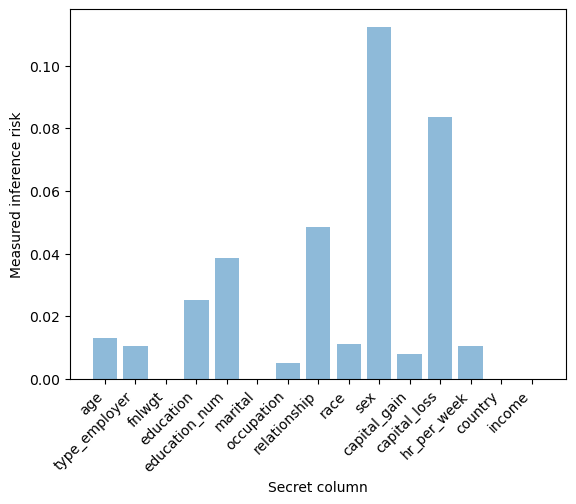

In [10]:
columns = df_ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=df_ori, 
                                   syn=df_syn, 
                                   control=df_ctr,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=2000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))
    
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

inference_result_syn = risks


ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

### $2$-Anonymized Data

Now, let's proceed to calculate both the utility and privacy risk metrics for the 2-anonymized data. 

> **Note:** The `de_anonymize` function just replaces values in the dataset with the mode of each respective column from the training data. This ensures that the anonymized dataset retains the same values as the training data, making it suitable for input into a Random Forest model and the Anonymeter evaluator.

In [11]:
df_2anon = pd.read_csv("../../data/adults_syn_ctgan_2_anonymized.csv")

df_2anon = de_anonymize(df_2anon, df_ori)

y_2anon = df_2anon[target_column].replace({'<=50K': 0, '>50K': 1})
X_2anon = df_2anon.drop(target_column, axis=1)

No possible deanonymized values for Asian-Pac-Islander


### Utility of $2$_Anonymized Data

In [12]:
y_2anon_proba = pipeline.predict_proba(X_2anon)[:, 1]
y_2anon_pred = (y_2anon_proba > 0.5).astype(int)

accuracy_2anon = accuracy_score(y_2anon, y_2anon_pred)
f1_2anon = f1_score(y_2anon, y_2anon_pred, average='weighted')
roc_auc_2anon = roc_auc_score(y_2anon, y_2anon_proba)

accuracy_list_anon.append(accuracy_2anon)
f1_score_list_anon.append(f1_2anon)
roc_list_anon.append(roc_auc_2anon)


print(f"Accuracy on 2-Anonymized Data: {accuracy_2anon}")
print(f"F1 Score on 2-Anonymized Data: {f1_2anon}")
print(f"ROC AUC on 2-Anonymized Data: {roc_auc_2anon}")

Accuracy on 2-Anonymized Data: 0.8071147713551503
F1 Score on 2-Anonymized Data: 0.7944980103751055
ROC AUC on 2-Anonymized Data: 0.8923942370891235


### Privacy Risk of $2$-Anonymized Data

#### Singling Out Risk

In [13]:
df_ctr = pd.read_csv(os.path.join("../../data/adults_control.csv"))

evaluator = SinglingOutEvaluator(ori=df_ori, 
                                 syn=df_2anon, 
                                 control=df_ctr,
                                 n_attacks=1000)

try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)
    singling_out_risk_anon.append(risk[0])

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.09737587359418233, ci=(0.06895770254417552, 0.12579404464418914))


#### Linkability Risk

In [14]:
aux_cols = [
    ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'country']
]

evaluator = LinkabilityEvaluator(ori=df_ori, 
                                 syn=df_2anon, 
                                 control=df_ctr,
                                 n_attacks=2000,
                                 aux_cols=aux_cols,
                                 n_neighbors=40)

evaluator.evaluate(n_jobs=-2)  
risk = evaluator.risk(confidence_level=0.95)
linkability_risk_anon.append(risk[0])
risk

PrivacyRisk(value=0.006860445293690616, ci=(0.0, 0.02201245209787551))

#### Inference Risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.04687033946568884, baseline = 0.05685116899287631. Analysis results cannot be trusted.
  self._sanity_check()


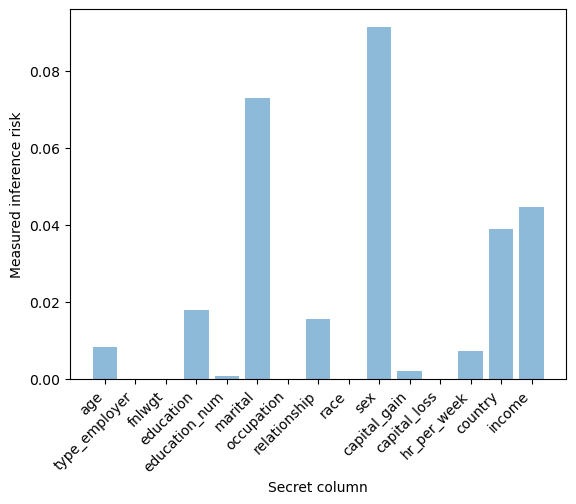

In [15]:
columns = df_ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=df_ori, 
                                   syn=df_2anon, 
                                   control=df_ctr,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=2000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))
    
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

inference_result_2anon = risks


ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

### $5$-Anonymized Data

In [16]:
df_5anon = pd.read_csv("../../data/adults_syn_ctgan_5_anonymized.csv")

df_5anon = de_anonymize(df_5anon, df_ori)

y_5anon = df_5anon[target_column].replace({'<=50K': 0, '>50K': 1})
X_5anon = df_5anon.drop(target_column, axis=1)

### Utility of $5$-Anonymized Data

In [17]:
y_5anon_proba = pipeline.predict_proba(X_5anon)[:, 1]
y_5anon_pred = (y_5anon_proba > 0.5).astype(int)

accuracy_5anon = accuracy_score(y_5anon, y_5anon_pred)
f1_5anon = f1_score(y_5anon, y_5anon_pred, average='weighted')
roc_auc_5anon = roc_auc_score(y_5anon, y_5anon_proba)


accuracy_list_anon.append(accuracy_5anon)
f1_score_list_anon.append(f1_5anon)
roc_list_anon.append(roc_auc_5anon)

print(f"Accuracy on 5-Anonymized Data: {accuracy_5anon}")
print(f"F1 Score on 5-Anonymized Data: {f1_5anon}")
print(f"ROC AUC on 5-Anonymized Data: {roc_auc_5anon}")

Accuracy on 5-Anonymized Data: 0.8069040247678019
F1 Score on 5-Anonymized Data: 0.7942778012496763
ROC AUC on 5-Anonymized Data: 0.892311651112721


### Privacy Risk of $5$-Anonymized Data

#### Singling Out Risk

In [18]:
df_ctr = pd.read_csv(os.path.join("../../data/adults_control.csv"))

evaluator = SinglingOutEvaluator(ori=df_ori, 
                                 syn=df_5anon, 
                                 control=df_ctr,
                                 n_attacks=1000)

try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)
    singling_out_risk_anon.append(risk[0])

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.10985470464712228, ci=(0.08060921564828986, 0.13910019364595472))


#### Linkability Risk

In [19]:
aux_cols = [
    ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'country']
]

evaluator = LinkabilityEvaluator(ori=df_ori, 
                                 syn=df_5anon, 
                                 control=df_ctr,
                                 n_attacks=2000,
                                 aux_cols=aux_cols,
                                 n_neighbors=300)

evaluator.evaluate(n_jobs=-2)  
risk = evaluator.risk(confidence_level=0.95)
linkability_risk_anon.append(risk[0])
risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9057207202801708, baseline = 0.9416517065780456. Analysis results cannot be trusted.
  self._sanity_check()


PrivacyRisk(value=0.0, ci=(0.0, 0.14050668197421046))

#### Inference Attack

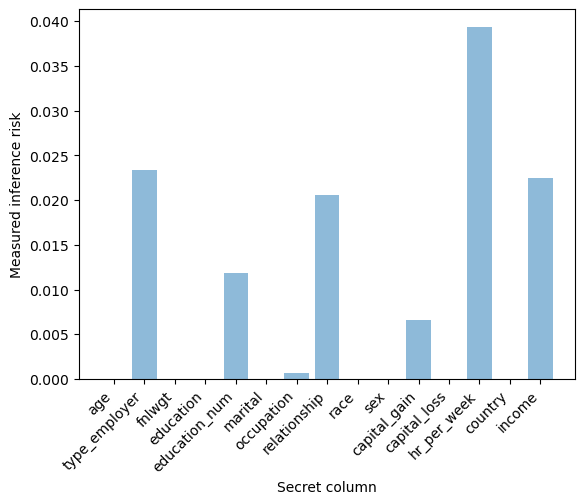

In [20]:
columns = df_ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=df_ori, 
                                   syn=df_5anon, 
                                   control=df_ctr,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=2000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))
    
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

inference_result_5anon = risks


ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

### $10$-Anonymized Data

In [21]:
df_10anon = pd.read_csv("../../data/adults_syn_ctgan_10_anonymized.csv")

df_10anon = de_anonymize(df_10anon, df_ori)

y_10anon = df_10anon[target_column].replace({'<=50K': 0, '>50K': 1})
X_10anon = df_10anon.drop(target_column, axis=1)

### Utility of $10$-Anonymized Data

In [22]:
y_10anon_proba = pipeline.predict_proba(X_10anon)[:, 1]
y_10anon_pred = (y_10anon_proba > 0.5).astype(int)

accuracy_10anon = accuracy_score(y_10anon, y_10anon_pred)
f1_10anon = f1_score(y_10anon, y_10anon_pred, average='weighted')
roc_auc_10anon = roc_auc_score(y_10anon, y_10anon_proba)

accuracy_list_anon.append(accuracy_10anon)
f1_score_list_anon.append(f1_10anon)
roc_list_anon.append(roc_auc_10anon)


print(f"Accuracy on 10-Anonymized Data: {accuracy_10anon}")
print(f"F1 Score on 10-Anonymized Data: {f1_10anon}")
print(f"ROC AUC on 10-Anonymized Data: {roc_auc_10anon}")

Accuracy on 10-Anonymized Data: 0.8069040247678019
F1 Score on 10-Anonymized Data: 0.7942778012496763
ROC AUC on 10-Anonymized Data: 0.892311651112721


### Privacy Risk of $10$-Anonymized Data

#### Singling Out Risk

In [23]:
df_ctr = pd.read_csv(os.path.join("../../data/adults_control.csv"))

evaluator = SinglingOutEvaluator(ori=df_ori, 
                                 syn=df_10anon, 
                                 control=df_ctr,
                                 n_attacks=1000)

try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)
    singling_out_risk_anon.append(risk[0])

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.1077634804963256, ci=(0.07846079618967988, 0.13706616480297132))


#### Linkability Risk

In [24]:
aux_cols = [
    ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'country']
]

evaluator = LinkabilityEvaluator(ori=df_ori, 
                                 syn=df_10anon, 
                                 control=df_ctr,
                                 n_attacks=2000,
                                 aux_cols=aux_cols,
                                 n_neighbors=300)

evaluator.evaluate(n_jobs=-2)  
risk = evaluator.risk(confidence_level=0.95)
linkability_risk_anon.append(risk[0])
risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9196938816182332, baseline = 0.9371603332908113. Analysis results cannot be trusted.
  self._sanity_check()


PrivacyRisk(value=0.12505387551331612, ci=(0.0, 0.3016776055050481))

#### Inference Risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.04886650537112633, baseline = 0.0493655468474857. Analysis results cannot be trusted.
  self._sanity_check()


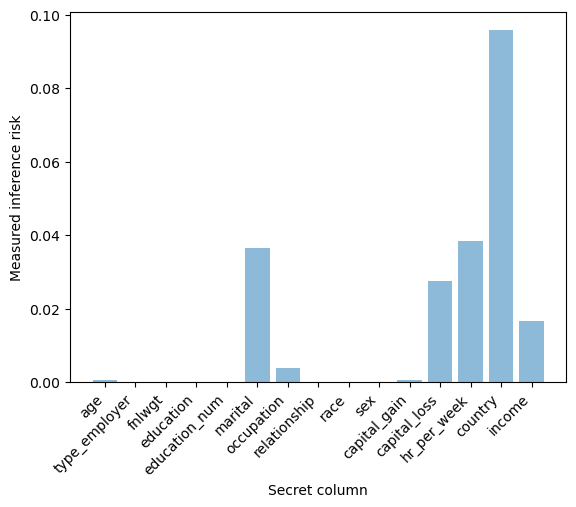

In [25]:
columns = df_ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=df_ori, 
                                   syn=df_10anon, 
                                   control=df_ctr,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=2000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))
    
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

inference_result_10anon = risks


ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

### $50$-Anonymized Data

In [26]:
df_50anon = pd.read_csv("../../data/adults_syn_ctgan_50_anonymized.csv")

df_50anon = de_anonymize(df_10anon, df_ori)

y_50anon = df_50anon[target_column].replace({'<=50K': 0, '>50K': 1})
X_50anon = df_50anon.drop(target_column, axis=1)

### Utility of $50$-Anonymized Data

In [27]:
y_50anon_proba = pipeline.predict_proba(X_50anon)[:, 1]
y_50anon_pred = (y_50anon_proba > 0.5).astype(int)

accuracy_50anon = accuracy_score(y_50anon, y_50anon_pred)
f1_50anon = f1_score(y_50anon, y_50anon_pred, average='weighted')
roc_auc_50anon = roc_auc_score(y_50anon, y_50anon_proba)

accuracy_list_anon.append(accuracy_50anon)
f1_score_list_anon.append(f1_50anon)
roc_list_anon.append(roc_auc_50anon)


print(f"Accuracy on 50-Anonymized Data: {accuracy_50anon}")
print(f"F1 Score on 50-Anonymized Data: {f1_50anon}")
print(f"ROC AUC on 50-Anonymized Data: {roc_auc_50anon}")

Accuracy on 50-Anonymized Data: 0.8069040247678019
F1 Score on 50-Anonymized Data: 0.7942778012496763
ROC AUC on 50-Anonymized Data: 0.892311651112721


### Privacy Risk of $50$-Anonymized Data

#### Singling Out Risk

In [28]:
df_ctr = pd.read_csv(os.path.join("../../data/adults_control.csv"))

evaluator = SinglingOutEvaluator(ori=df_ori, 
                                 syn=df_50anon, 
                                 control=df_ctr,
                                 n_attacks=1000)

try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)
    singling_out_risk_anon.append(risk[0])

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.09955265278089165, ci=(0.07003628979364282, 0.12906901576814048))


#### Linkability Risk

In [29]:
aux_cols = [
    ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'country']
]

evaluator = LinkabilityEvaluator(ori=df_ori, 
                                 syn=df_50anon, 
                                 control=df_ctr,
                                 n_attacks=2000,
                                 aux_cols=aux_cols,
                                 n_neighbors=300)

evaluator.evaluate(n_jobs=-2)  
risk = evaluator.risk(confidence_level=0.95)
linkability_risk_anon.append(risk[0])
risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9072178447092489, baseline = 0.9436478724834831. Analysis results cannot be trusted.
  self._sanity_check()


PrivacyRisk(value=0.0510410512971064, ci=(0.0, 0.2318461952186784))

#### Inference Risk

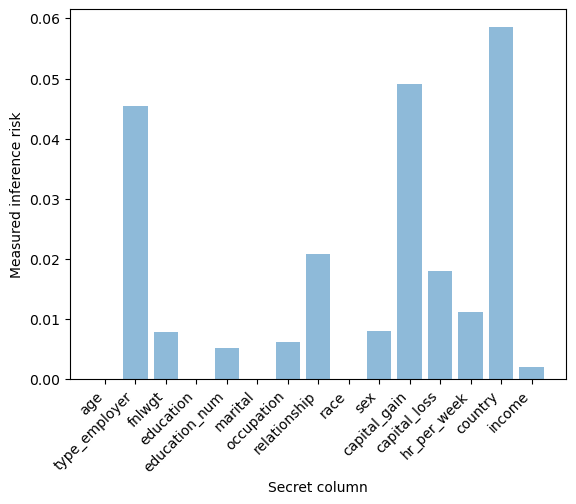

In [30]:
columns = df_ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=df_ori, 
                                   syn=df_50anon, 
                                   control=df_ctr,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=2000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))
    
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

inference_result_50anon = risks


ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

## Step 4: Calculate Metrics With Noisy Data

In this segment of the experiment, we introduce noise to the data using our implemented `add_noise` module. After perturbing the data, we proceed to compute our metrics, similar to our previous methodology.

### Low Noise

In [31]:
df_lnoise = add_noise(df_syn, 'low')

y_lnoise = df_lnoise[target_column].replace({'<=50K': 0, '>50K': 1})
X_lnoise = df_lnoise.drop(target_column, axis=1)

### Calculate Utility of Data With Low Noise

In [32]:
accuracy_noisy = []
f1_score_noisy = []
roc_noisy = []
singling_out_risk_noisy = []
linkability_risk_noisy = []


df_lnoise = add_noise(df_syn, 'low')

y_lnoise_proba = pipeline.predict_proba(X_lnoise)[:, 1]
y_lnoise_pred = (y_lnoise_proba > 0.5).astype(int)

accuracy_lnoise = accuracy_score(y_lnoise, y_lnoise_pred)
f1_lnoise = f1_score(y_lnoise, y_lnoise_pred, average='weighted')
roc_auc_lnoise = roc_auc_score(y_lnoise, y_lnoise_proba)

accuracy_noisy.append(accuracy_lnoise)
f1_score_noisy.append(f1_lnoise)
roc_noisy.append(roc_auc_lnoise)



print(f"Accuracy on Low Noise Data: {accuracy_lnoise}")
print(f"F1 Score on Low Noise Data: {f1_lnoise}")
print(f"ROC AUC on Low Noise Data: {roc_auc_lnoise}")


Accuracy on Low Noise Data: 0.8220030737704918
F1 Score on Low Noise Data: 0.8090647223050464
ROC AUC on Low Noise Data: 0.8970178791063357


### Calculate Risk on Data With Low Noise

#### Singling Out Risk

In [33]:
df_ctr = pd.read_csv(os.path.join("../../data/adults_control.csv"))

evaluator = SinglingOutEvaluator(ori=df_ori, 
                                 syn=df_lnoise, 
                                 control=df_ctr,
                                 n_attacks=1000)

try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)
    singling_out_risk_noisy.append(risk[0])

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.07887087052296775, ci=(0.055693914024160435, 0.10204782702177506))


#### Linkability Risk

In [34]:
aux_cols = [
    ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'country']
]

evaluator = LinkabilityEvaluator(ori=df_ori, 
                                 syn=df_lnoise, 
                                 control=df_ctr,
                                 n_attacks=2000,
                                 aux_cols=aux_cols,
                                 n_neighbors=300)

evaluator.evaluate(n_jobs=-2)  
risk = evaluator.risk(confidence_level=0.95)
linkability_risk_noisy.append(risk[0])
risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.8807686464622021, baseline = 0.9097130520910458. Analysis results cannot be trusted.
  self._sanity_check()


PrivacyRisk(value=0.0, ci=(0.0, 0.13388248804270297))

#### Inference Risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.052858837182001316, baseline = 0.05784925194559505. Analysis results cannot be trusted.
  self._sanity_check()
/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.1267169756831886, baseline = 0.13719684668673546. Analysis results cannot be trusted.
  self._sanity_check()


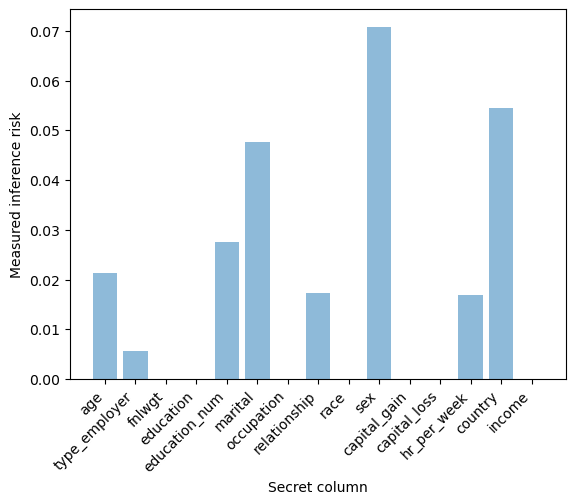

In [35]:
columns = df_ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=df_ori, 
                                   syn=df_lnoise, 
                                   control=df_ctr,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=2000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

inference_result_lnoise = risks


ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

### Medium Noise

In [36]:
df_mnoise = add_noise(df_syn, 'medium')

y_mnoise = df_mnoise[target_column].replace({'<=50K': 0, '>50K': 1})
X_mnoise = df_mnoise.drop(target_column, axis=1)

### Calculate Utility of Data with Medium Noise

In [37]:
y_mnoise_proba = pipeline.predict_proba(X_mnoise)[:, 1]
y_mnoise_pred = (y_mnoise_proba > 0.5).astype(int)

accuracy_mnoise = accuracy_score(y_mnoise, y_mnoise_pred)
f1_mnoise = f1_score(y_mnoise, y_mnoise_pred, average='weighted')
roc_auc_mnoise = roc_auc_score(y_mnoise, y_mnoise_proba)

accuracy_noisy.append(accuracy_mnoise)
f1_score_noisy.append(f1_mnoise)
roc_noisy.append(roc_auc_mnoise)

print(f"Accuracy on Medium Noise Data: {accuracy_mnoise}")
print(f"F1 Score on Medium Noise Data: {f1_mnoise}")
print(f"ROC AUC on Medium Noise Data: {roc_auc_mnoise}")


Accuracy on Medium Noise Data: 0.8142418032786886
F1 Score on Medium Noise Data: 0.7981418154677183
ROC AUC on Medium Noise Data: 0.8888416866807803


### Calculate Privacy Risk of Data with Medium Noise

#### Singling Out Risk

In [38]:
df_ctr = pd.read_csv(os.path.join("../../data/adults_control.csv"))

evaluator = SinglingOutEvaluator(ori=df_ori, 
                                 syn=df_mnoise, 
                                 control=df_ctr,
                                 n_attacks=1000)

try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)
    singling_out_risk_noisy.append(risk[0])

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.04532083676440139, ci=(0.02262363284441467, 0.06801804068438812))


#### Linkability Risk

In [39]:
aux_cols = [
    ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'country']
]

evaluator = LinkabilityEvaluator(ori=df_ori, 
                                 syn=df_mnoise, 
                                 control=df_ctr,
                                 n_attacks=2000,
                                 aux_cols=aux_cols,
                                 n_neighbors=300)

evaluator.evaluate(n_jobs=-2)  
risk = evaluator.risk(confidence_level=0.95)
linkability_risk_noisy.append(risk[0])
risk

PrivacyRisk(value=0.0, ci=(0.0, 0.15734165568622166))

#### Inference Risk

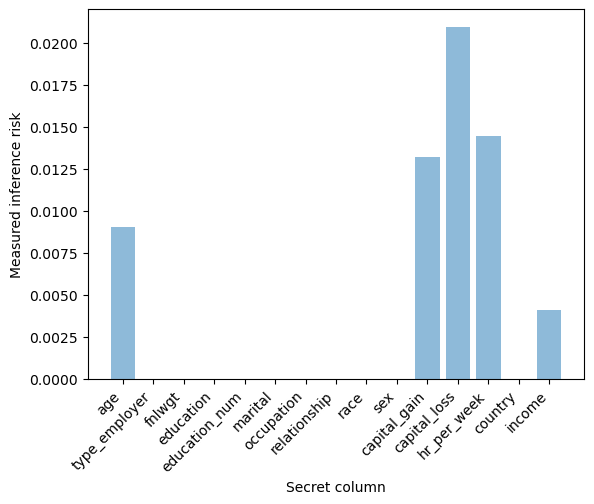

In [40]:
columns = df_ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=df_ori, 
                                   syn=df_mnoise, 
                                   control=df_ctr,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=2000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

inference_result_mnoise = risks


ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

### High Noise

In [41]:
df_hnoise = add_noise(df_syn, 'high')

y_hnoise = df_hnoise[target_column].replace({'<=50K': 0, '>50K': 1})
X_hnoise = df_hnoise.drop(target_column, axis=1)


### Calculate Utility of Data With High Noise

In [42]:
y_hnoise_proba = pipeline.predict_proba(X_hnoise)[:, 1]
y_hnoise_pred = (y_hnoise_proba > 0.5).astype(int)

accuracy_hnoise = accuracy_score(y_hnoise, y_hnoise_pred)
f1_hnoise = f1_score(y_hnoise, y_hnoise_pred, average='weighted')
roc_auc_hnoise = roc_auc_score(y_hnoise, y_hnoise_proba)

accuracy_noisy.append(accuracy_hnoise)
f1_score_noisy.append(f1_hnoise)
roc_noisy.append(roc_auc_hnoise)

print(f"Accuracy on High Noise Data: {accuracy_hnoise}")
print(f"F1 Score on High Noise Data: {f1_hnoise}")
print(f"ROC AUC on High Noise Data: {roc_auc_hnoise}")


Accuracy on High Noise Data: 0.8036885245901639
F1 Score on High Noise Data: 0.7831021071352258
ROC AUC on High Noise Data: 0.8744298360461742


### Calculate Privacy Risk of Data With High Noise

#### Singling Out Risk

In [43]:
df_ctr = pd.read_csv(os.path.join("../../data/adults_control.csv"))

evaluator = SinglingOutEvaluator(ori=df_ori, 
                                 syn=df_hnoise, 
                                 control=df_ctr,
                                 n_attacks=1000)

try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)
    singling_out_risk_noisy.append(risk[0])

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.07152103634580176, ci=(0.04609223349078778, 0.09694983920081574))


#### Linkability Risk

In [44]:
aux_cols = [
    ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'country']
]

evaluator = LinkabilityEvaluator(ori=df_ori, 
                                 syn=df_hnoise, 
                                 control=df_ctr,
                                 n_attacks=2000,
                                 aux_cols=aux_cols,
                                 n_neighbors=300)

evaluator.evaluate(n_jobs=-2)  
risk = evaluator.risk(confidence_level=0.95)
linkability_risk_noisy.append(risk[0])
risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.8987341396111396, baseline = 0.9007303055165771. Analysis results cannot be trusted.
  self._sanity_check()


PrivacyRisk(value=0.0, ci=(0.0, 0.1101170541376173))

#### Inference Risk

/opt/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.13021026601770422, baseline = 0.1456805517848448. Analysis results cannot be trusted.
  self._sanity_check()


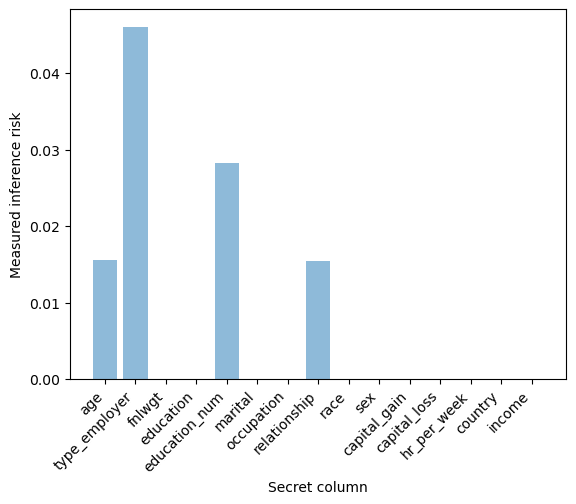

In [45]:
columns = df_ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=df_ori, 
                                   syn=df_hnoise, 
                                   control=df_ctr,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=2000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

inference_result_hnoise = risks


ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

## Step 5: Visualize Results

### Inference Risk Grouped Bar Chart

The first visualization we'll create is a grouped bar chart showcasing the inferability risk results of each dataset. This visualization will emphasize the differences in Inference Risk between datasets.

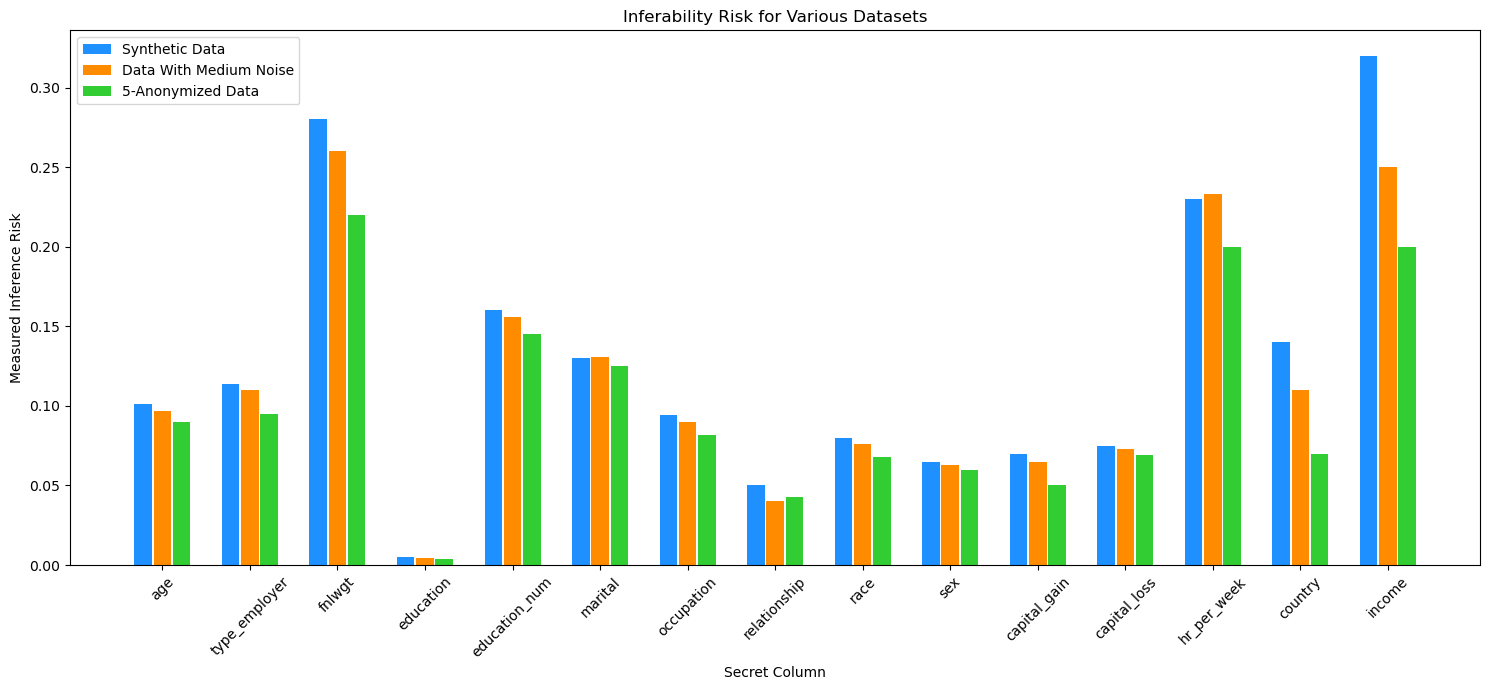

In [53]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['age', 'type_employer', 'fnlwgt', 'education', 'education_num',
          'marital', 'occupation', 'relationship', 'race', 'sex', 'capital_gain',
          'capital_loss', 'hr_per_week', 'country', 'income']

width = 0.2  
spacing = 0.02  
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(15,7))

rects1 = ax.bar(x - width - spacing, inference_result_syn, width, label='Synthetic Data', color='dodgerblue')
rects2 = ax.bar(x, inference_result_mnoise, width, label='Data With Medium Noise', color='darkorange')
rects4 = ax.bar(x + width + spacing, inference_result_5anon, width, label='5-Anonymized Data', color='limegreen')

ax.set_xlabel('Secret Column')
ax.set_ylabel('Measured Inference Risk')
ax.set_title('Inferability Risk for Various Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("Inference Risk.png")

plt.show()


### Plotting Calculated Metrics For Anonymized Data

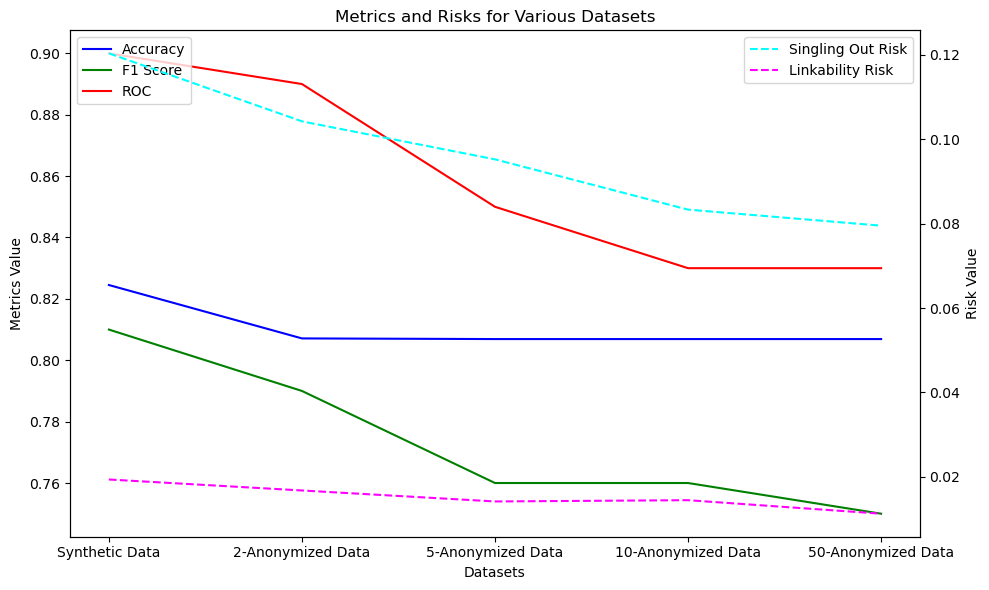

In [52]:
import matplotlib.pyplot as plt


x = ['Synthetic Data', '2-Anonymized Data', '5-Anonymized Data', '10-Anonymized Data', '50-Anonymized Data']

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot metrics on primary y-axis
ax1.plot(x, accuracy_list_anon, label='Accuracy', color='blue')
ax1.plot(x, f1_score_list_anon, label='F1 Score', color='green')
ax1.plot(x, roc_list_anon, label='ROC', color='red')
ax1.set_ylabel('Metrics Value')
ax1.set_xlabel('Datasets')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0))

# Initialize secondary y-axis for risks
ax2 = ax1.twinx()

# Plot risks on secondary y-axis
ax2.plot(x, singling_out_risk_anon, label='Singling Out Risk', color='cyan', linestyle='--')
ax2.plot(x, linkability_risk_anon, label='Linkability Risk', color='magenta', linestyle='--')
ax2.set_ylabel('Risk Value')
ax2.legend(loc='upper right')  # This moves the legend for the dashed lines to the right.

# Set the title and display the plot
plt.title("Metrics and Risks for Various Datasets")
plt.tight_layout()

plt.savefig("Metrics_Comparison_for_Anonymized_Datasets.png", bbox_inches='tight', dpi=300)

plt.show()


### Plotting Calculated Metrics For Data with Noise Addition

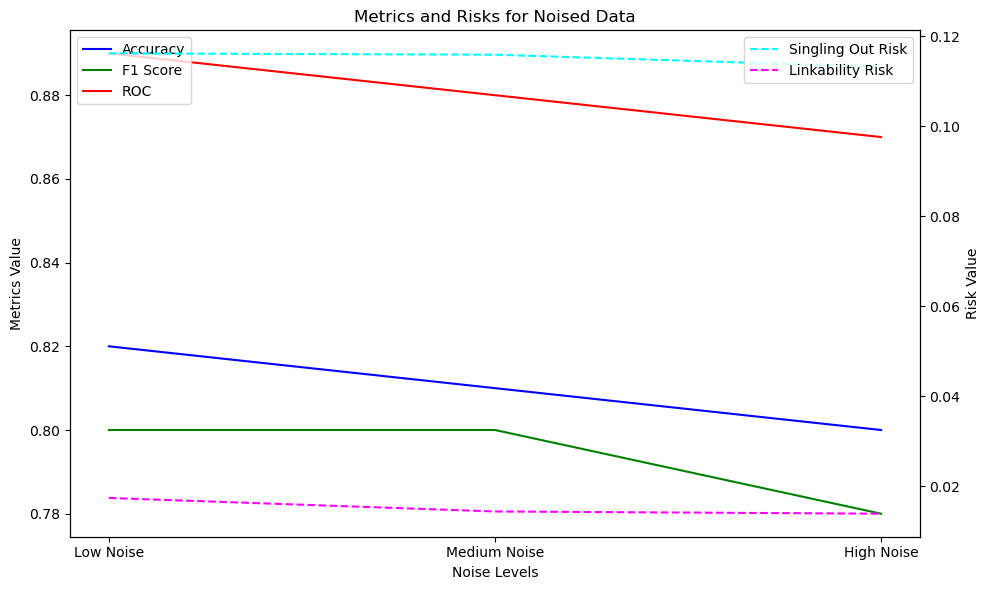

In [51]:
import matplotlib.pyplot as plt

x = ['Low Noise', 'Medium Noise', 'High Noise']

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(x, accuracy_noisy, label='Accuracy', color='blue')
ax1.plot(x, f1_score_list_noisy, label='F1 Score', color='green')
ax1.plot(x, roc_list_noisy, label='ROC', color='red')
ax1.set_ylabel('Metrics Value')
ax1.set_xlabel('Noise Levels')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0))

ax2 = ax1.twinx()

ax2.plot(x, singling_out_risk_noisy, label='Singling Out Risk', color='cyan', linestyle='--')
ax2.plot(x, linkability_risk_noisy, label='Linkability Risk', color='magenta', linestyle='--')
ax2.set_ylabel('Risk Value')
ax2.legend(loc='upper right')

plt.title("Metrics and Risks for Noised Data")
plt.tight_layout()

plt.savefig("Metrics_Comparison_for_Noisy_Datasets.png", bbox_inches='tight', dpi=300)

plt.show()


### Plotting the Heatmap of Metrics and Datasets

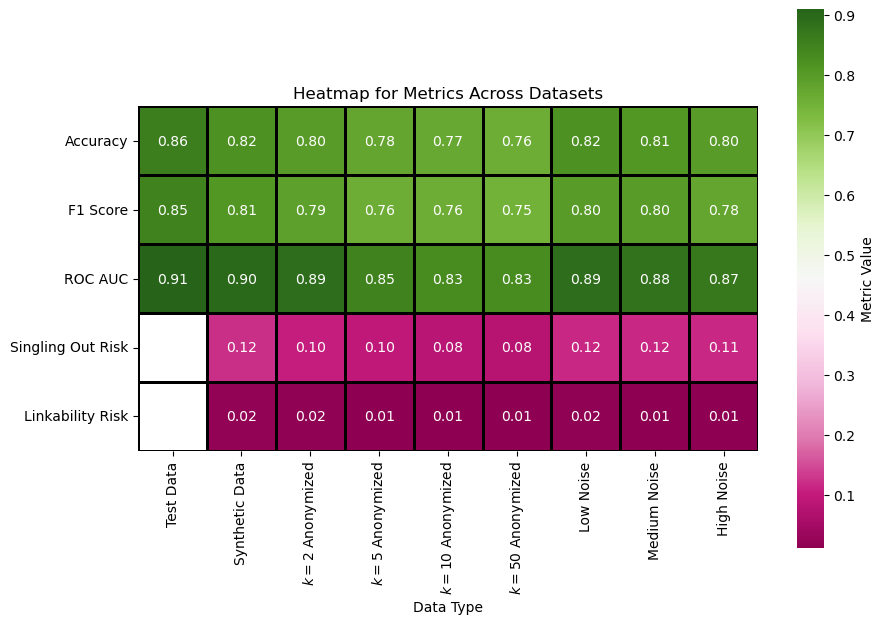

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



df = pd.DataFrame(data)

df = df.set_index('Data Type').T

plt.figure(figsize=(10, 7))
sns.heatmap(df, cmap="PiYG", annot=True, cbar_kws={'label': 'Metric Value'}, fmt=".2f", linewidths=1, linecolor='black', square=True)
plt.title('Heatmap for Metrics Across Datasets')

plt.savefig("Heatmap_of_Metrics.png", bbox_inches='tight', dpi=300)

plt.show()
